In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Configuration
DATA_ROOTS = [
    # r"/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/MDVR RGB",
    r"/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/Italian RGB 3"
]


# 20epochs variant ran with these 
# #Chunkification technique used
# S = librosa.feature.melspectrogram(
#         y=y, 
#         sr=sr, 
#         n_fft=1024,           # Increased for better frequency resolution
#         hop_length=64,       # Smaller for smoother time transitions
#         n_mels=224,           # More mel bands initially
#         fmin=0,              # Focus on this frequency range
#         fmax=4000
#     )


# 50epochs variant ran with hop length 30 variant


BATCH_SIZE = 32
NUM_WORKERS = 4  # Optimize based on CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset Class
class ParkinsonSpectrogramDataset(Dataset):
    def __init__(self, root_dirs, transform=None):
        if isinstance(root_dirs, str):  # If a single path is given, convert it to a list
            root_dirs = [root_dirs]
        self.root_dirs = root_dirs
        self.transform = transform
        self.samples = self._load_samples()
        
    def _load_samples(self):
        samples = []
        for root_dir in self.root_dirs:
            for class_name in ['HC', 'PD']:
                class_dir = os.path.join(root_dir, class_name)
                if not os.path.exists(class_dir):
                    continue

                # Traverse subfolders inside HC/PD
                for patient_folder in os.listdir(class_dir):
                    patient_path = os.path.join(class_dir, patient_folder)
                    if os.path.isdir(patient_path):  # Ensure it's a directory
                        for img_file in os.listdir(patient_path):
                            if img_file.lower().endswith('.png'):  # Only PNG images
                                img_path = os.path.join(patient_path, img_file)
                                samples.append((img_path, 0 if class_name == 'HC' else 1))

        print(f"✅ Loaded {len(samples)} samples from {self.root_dirs}")
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')  # Convert to RGB
        if self.transform:
            img = self.transform(img)
        return img, label
        

# ============================
# ✅ Data Transforms
# ============================

# For training: add augmentations
train_transform = transforms.Compose([
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
    ], p=0.5),  # Color jitter 50% of the time
    transforms.RandomRotation(degrees=5),  # Small rotations
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Small translations
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.0), ratio=(0.9, 1.1)),  # Random crops
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Keep it ImageNet because pretrained DenseNet expects it
                         std=[0.229, 0.224, 0.225]),
])

# For validation and testing: no augmentation, just resize and normalize
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize without crop
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Same normalization for consistency
                         std=[0.229, 0.224, 0.225]),
])


# Create Datasets (Loading from both MDVR & Italian datasets)
train_dataset = ParkinsonSpectrogramDataset([os.path.join(root, 'train') for root in DATA_ROOTS], transform=train_transform)
val_dataset = ParkinsonSpectrogramDataset([os.path.join(root, 'val') for root in DATA_ROOTS], transform=test_transform)
test_dataset = ParkinsonSpectrogramDataset([os.path.join(root, 'test') for root in DATA_ROOTS], transform=test_transform)

# Optimized DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                          num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=False)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=False)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                         num_workers=NUM_WORKERS, pin_memory=True)

print(f"✅ DataLoaders ready! Using device: {DEVICE}")

✅ Loaded 79613 samples from ['/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/Italian RGB 3/train']
✅ Loaded 16792 samples from ['/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/Italian RGB 3/val']
✅ Loaded 16861 samples from ['/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/Italian RGB 3/test']
✅ DataLoaders ready! Using device: cuda


In [2]:
# 🚀 Full Pipeline for Pretrained EfficientNetV2 with RGB Spectrograms

import os
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from tqdm import tqdm

# ============================
# ✅ Configuration
# ============================
# DATA_DIR = "/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/MDVR RGB"
# DATA_DIR = "/home/nigmu/NPersonal/Projects/SDP/nigmu-parkinsons_disease_prediction/Dataset/Italian RGB"
# BATCH_SIZE = 32
NUM_CLASSES = 2
EPOCHS = 50
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================
# ✅ Data Transforms
# ============================
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize from (496x200) to 224x224 for DenseNet
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225]),
# ])

# ============================
# ✅ Dataset and DataLoader
# ============================
# train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=transform)
# val_dataset   = datasets.ImageFolder(os.path.join(DATA_DIR, 'val'), transform=transform)
# test_dataset  = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), transform=transform)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
# val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
# test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ============================
# ✅ Model Definition
# ============================


# # mFrom here 
class CustomEfficientNetV2(nn.Module):
    def __init__(self, num_classes):
        super(CustomEfficientNetV2, self).__init__()
        
        # EfficientNetV2 model (small, medium, or large)
        # Use 'weights=models.EfficientNet_V2_S_Weights.DEFAULT' to load pre-trained weights
        self.base_model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)  # You can swap to _m or _l

        # The number of input features for the classifier layer
        in_features = self.base_model.classifier[1].in_features
        
        # Replacing the final classifier with the number of output classes you need
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.3),  # Dropout for regularization
            nn.Linear(in_features, num_classes)  # Output layer for your classification task
        )
    
    def forward(self, x):
        return self.base_model(x)

# Usage
model = CustomEfficientNetV2(num_classes=NUM_CLASSES).to(DEVICE)


# ============================
# ✅ Loss and Optimizer
# ============================
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ============================
# ✅ Training and Validation Loop
# ============================


# Store metrics for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_accuracy = None  # Final test accuracy



def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(loader, desc="Training", leave=False)
    for images, labels in loop:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

    return running_loss / total, correct / total

def validate_epoch(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        loop = tqdm(loader, desc="Validation", leave=False)
        for images, labels in loop:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

    return running_loss / total, correct / total

# ============================
# ✅ Run Training
# ============================
for epoch in range(EPOCHS):
    print(f"\n🌟 Epoch {epoch+1}/{EPOCHS}")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion)

    # Save metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    
    print(f"\n📈 Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

# ============================
# ✅ Testing
# ============================
def test_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100. * correct / total
    print(f"\n✅ Test Accuracy: {acc:.2f}%")
    return acc  # <- Return value for test_accuracy

# Run test
print("\n🚀 Testing best model...")
test_accuracy = test_model(model, test_loader)


🌟 Epoch 1/50



📈 Train Loss: 0.1318, Acc: 0.9480 | Val Loss: 0.0367, Acc: 0.9881

🌟 Epoch 2/50



📈 Train Loss: 0.0585, Acc: 0.9789 | Val Loss: 0.0385, Acc: 0.9859

🌟 Epoch 3/50



📈 Train Loss: 0.0429, Acc: 0.9847 | Val Loss: 0.0356, Acc: 0.9875

🌟 Epoch 4/50



📈 Train Loss: 0.0346, Acc: 0.9877 | Val Loss: 0.0648, Acc: 0.9849

🌟 Epoch 5/50



📈 Train Loss: 0.0310, Acc: 0.9889 | Val Loss: 0.0246, Acc: 0.9910

🌟 Epoch 6/50



📈 Train Loss: 0.0257, Acc: 0.9906 | Val Loss: 0.0376, Acc: 0.9876

🌟 Epoch 7/50



📈 Train Loss: 0.0241, Acc: 0.9915 | Val Loss: 0.0458, Acc: 0.9827

🌟 Epoch 8/50



📈 Train Loss: 0.0217, Acc: 0.9921 | Val Loss: 0.0306, Acc: 0.9894

🌟 Epoch 9/50



📈 Train Loss: 0.0198, Acc: 0.9930 | Val Loss: 0.0226, Acc: 0.9930

🌟 Epoch 10/50



📈 Train Loss: 0.0188, Acc: 0.9934 | Val Loss: 0.0377, Acc: 0.9879

🌟 Epoch 11/50



📈 Train Loss: 0.0177, Acc: 0.9937 | Val Loss: 0.0359, Acc: 0.9865

🌟 Epoch 12/50



📈 Train Loss: 0.0164, Acc: 0.9937 | Val Loss: 0.0594, Acc: 0.9803

🌟 Epoch 13/50



📈 Train Loss: 0.0148, Acc: 0.9945 | Val Loss: 0.0413, Acc: 0.9866

🌟 Epoch 14/50



📈 Train Loss: 0.0147, Acc: 0.9948 | Val Loss: 0.0512, Acc: 0.9833

🌟 Epoch 15/50



📈 Train Loss: 0.0138, Acc: 0.9951 | Val Loss: 0.0406, Acc: 0.9861

🌟 Epoch 16/50



📈 Train Loss: 0.0142, Acc: 0.9950 | Val Loss: 0.0529, Acc: 0.9836

🌟 Epoch 17/50



📈 Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.0378, Acc: 0.9877

🌟 Epoch 18/50



📈 Train Loss: 0.0126, Acc: 0.9954 | Val Loss: 0.0246, Acc: 0.9923

🌟 Epoch 19/50



📈 Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.0521, Acc: 0.9861

🌟 Epoch 20/50



📈 Train Loss: 0.0111, Acc: 0.9960 | Val Loss: 0.0248, Acc: 0.9926

🌟 Epoch 21/50



📈 Train Loss: 0.0109, Acc: 0.9959 | Val Loss: 0.0480, Acc: 0.9880

🌟 Epoch 22/50



📈 Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.0655, Acc: 0.9817

🌟 Epoch 23/50



📈 Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.0454, Acc: 0.9886

🌟 Epoch 24/50



📈 Train Loss: 0.0101, Acc: 0.9964 | Val Loss: 0.0250, Acc: 0.9917

🌟 Epoch 25/50



📈 Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0394, Acc: 0.9886

🌟 Epoch 26/50



📈 Train Loss: 0.0090, Acc: 0.9967 | Val Loss: 0.0420, Acc: 0.9883

🌟 Epoch 27/50



📈 Train Loss: 0.0088, Acc: 0.9968 | Val Loss: 0.0342, Acc: 0.9911

🌟 Epoch 28/50



📈 Train Loss: 0.0087, Acc: 0.9968 | Val Loss: 0.0415, Acc: 0.9867

🌟 Epoch 29/50



📈 Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0274, Acc: 0.9924

🌟 Epoch 30/50



📈 Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0347, Acc: 0.9903

🌟 Epoch 31/50



📈 Train Loss: 0.0081, Acc: 0.9970 | Val Loss: 0.0241, Acc: 0.9927

🌟 Epoch 32/50



📈 Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0366, Acc: 0.9912

🌟 Epoch 33/50



📈 Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.0356, Acc: 0.9911

🌟 Epoch 34/50



📈 Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.0278, Acc: 0.9918

🌟 Epoch 35/50



📈 Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0290, Acc: 0.9912

🌟 Epoch 36/50



📈 Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0438, Acc: 0.9879

🌟 Epoch 37/50



📈 Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.0495, Acc: 0.9873

🌟 Epoch 38/50



📈 Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0296, Acc: 0.9913

🌟 Epoch 39/50



📈 Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0461, Acc: 0.9856

🌟 Epoch 40/50



📈 Train Loss: 0.0067, Acc: 0.9974 | Val Loss: 0.0366, Acc: 0.9896

🌟 Epoch 41/50



📈 Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0338, Acc: 0.9884

🌟 Epoch 42/50



📈 Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0291, Acc: 0.9905

🌟 Epoch 43/50



📈 Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0425, Acc: 0.9886

🌟 Epoch 44/50



📈 Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0381, Acc: 0.9899

🌟 Epoch 45/50



📈 Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0502, Acc: 0.9877

🌟 Epoch 46/50



📈 Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.0393, Acc: 0.9890

🌟 Epoch 47/50



📈 Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0304, Acc: 0.9912

🌟 Epoch 48/50



📈 Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0395, Acc: 0.9891

🌟 Epoch 49/50



📈 Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.0293, Acc: 0.9911

🌟 Epoch 50/50



📈 Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0225, Acc: 0.9933

🚀 Testing best model...


Testing: 100%|██████████████████████████████| 1054/1054 [01:14<00:00, 14.22it/s]


✅ Test Accuracy: 99.44%


In [6]:
# Save the trained model
torch.save(model.state_dict(), 'best_model8.pth')
print("✅ Model saved as 'best_model8.pth'")

✅ Model saved as 'best_model8.pth'



🚀 Testing best model...


Testing: 100%|██████████████████████████████| 1054/1054 [01:14<00:00, 14.15it/s]



✅ Test Accuracy: 99.44%


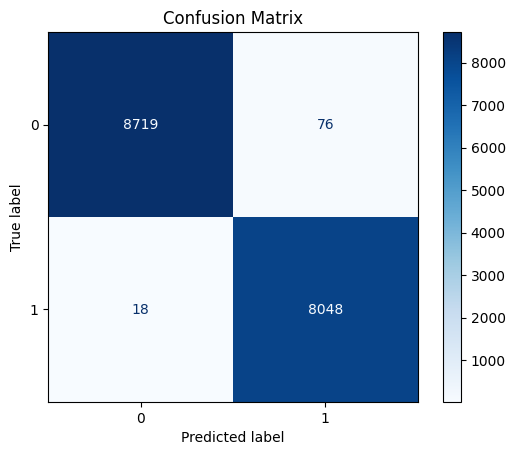


📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9979    0.9914    0.9946      8795
           1     0.9906    0.9978    0.9942      8066

    accuracy                         0.9944     16861
   macro avg     0.9943    0.9946    0.9944     16861
weighted avg     0.9945    0.9944    0.9944     16861



In [11]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torchvision import models
from tqdm import tqdm

# ============================
# ✅ Configuration
# ============================
NUM_CLASSES = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================
# ✅ Model Definition (Matching Training)
# ============================
class CustomEfficientNetV2(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(CustomEfficientNetV2, self).__init__()
        self.base_model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
        in_features = self.base_model.classifier[1].in_features
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, num_classes)
        )
    
    def forward(self, x):
        return self.base_model(x)

# ============================
# ✅ Load the Model
# ============================
model8 = CustomEfficientNetV2(num_classes=NUM_CLASSES).to(DEVICE)
model8.load_state_dict(torch.load("best_model8.pth"))
model8.eval()

# ============================
# ✅ Testing Function
# ============================
def test_model8(model, loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = 100. * correct / total
    print(f"\n✅ Test Accuracy: {acc:.2f}%")

    # 📊 Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

    # 📋 Classification Report
    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

# ============================
# ✅ Run the Test
# ============================
print("\n🚀 Testing best model...")
test_model8(model8, test_loader)


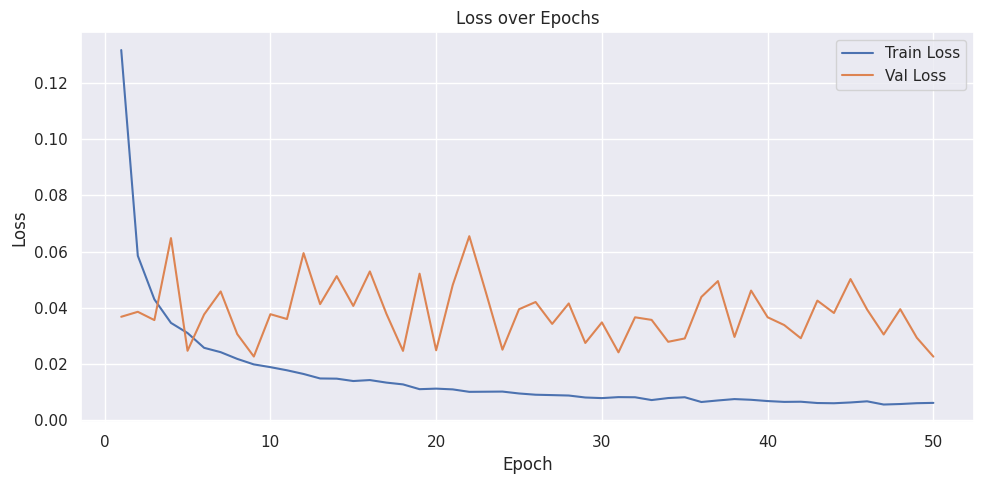

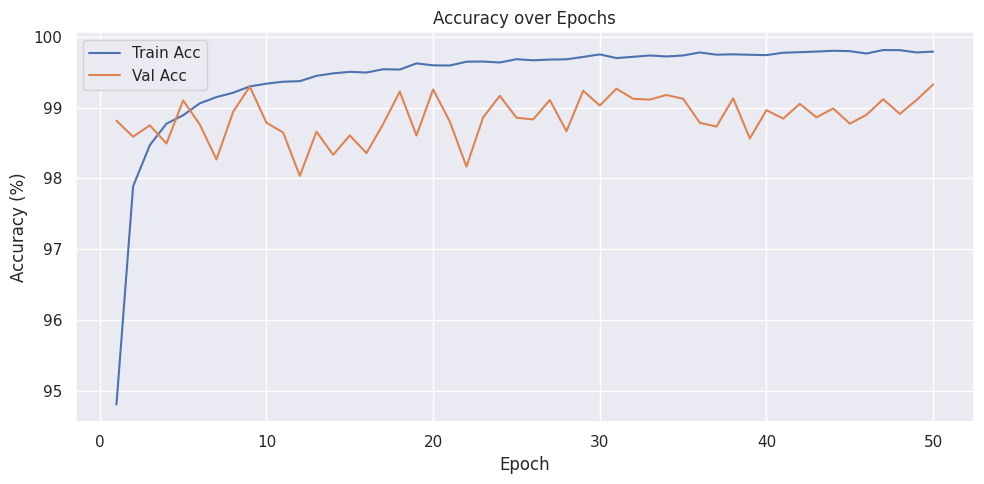

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the Seaborn “darkgrid” theme
sns.set_theme(style="darkgrid")

# Now your original plotting code works:
epochs_range = range(1, EPOCHS + 1)

# 🔹 Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses,   label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# 🔹 Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, [a * 100 for a in train_accuracies], label='Train Acc')
plt.plot(epochs_range, [a * 100 for a in val_accuracies],   label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()